In [3]:
CLIENT_ID = "seuid"
SECRET_KEY = "suasenha"

In [4]:
import requests
import pandas as pd

In [5]:
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)

In [6]:
with open('pw.txt', 'r') as f:
    pw = f.read()

In [7]:
data = {
    'grant_type': 'password',
    'username': 'seuid',
    'password': pw
}

In [8]:
headers = {'User-Agent': 'MyAPI/0.01'}

In [9]:
res = requests.post('https://www.reddit.com/api/v1/access_token', 
                   auth=auth, data=data, headers=headers)

In [10]:
TOKEN = res.json()['access_token']

In [11]:
headers = {**headers, **{'Authorization': f'bearer {TOKEN}'}}

In [12]:
# headers

In [13]:
# requests.get('https://oauth.reddit.com/api/v1/me', headers={'User-Agent': 'MyAPI/0.01'})

In [14]:
# requests.get('https://oauth.reddit.com/api/v1/me', headers=headers).json()

In [15]:
res = requests.get('https://oauth.reddit.com/r/Discussion/hot',
                headers=headers, params={'limit': '100'})

In [179]:
all_posts_data = []

for post in res.json()['data']['children']:
    post_data_dict = {
        'id_post': post['data'].get('id'),
        'title': post['data'].get('title'),
        'author': post['data'].get('author'),
        'subreddit': post['data'].get('subreddit'),
        'ups': post['data'].get('ups'),
        'upvote_ratio': post['data'].get('upvote_ratio'),
        'downs': post['data'].get('downs'),
        'score': post['data'].get('score'),
        'num_comments': post['data'].get('num_comments'),
        'is_self': post['data'].get('is_self'), 
        'selftext': post['data'].get('selftext', ''),
        'created_utc': post['data'].get('created_utc')
    }
    all_posts_data.append(post_data_dict)

df = pd.DataFrame(all_posts_data)

## Descrição da Base de Dados e Atributos Coletados

### Atributos Originais

Para esta atividade, foram coletados os dados sobre os posts do subreddit "Discussion". A coleta foi feita através da API do Reddit, resultando em um conjunto de 102 postagens. 
Esta base de dados, ainda em seu formato bruto, contém as seguintes informações para cada postagem:
- id_post: ID do post;
- title: Título do post;
- author: Autor do post;
- subreddit: Subreddit referente ao post;
- ups: Número de "upvotes" que o post recebeu;
- upvote_ratio: Proporção de "upvotes" em relação ao total de votos ("upvotes" + "downvotes");
- downs: Número de "downvotes" que o post recebeu;
- score: Pontuação do post calculada como "ups" - "downs";
- num_commets: Número de comentários do post;
- is_self: : Indica se o post é um post de texto (True) ou post de um link externo (False);
- selftext: Contém o corpo do texto do post (caso seja um post de texto);
- created_ufc: Timestamp Unix da criação do post

### Atributos Derivados

Número de caracteres presentes no título da postagem. Essa informação pode ajudar a analisar se a concisão ou a extenão do título influenciam o engajamento ou o tipo de conteúdo.

In [180]:
df['len_title'] = df['title'].str.len()

Representação em formato de data e hora legível do timestamp Unix da criação da postagem. Essa informação é útil pois ajuda a extrair informações temporais mais granulares.

In [181]:
df['datetime'] = pd.to_datetime(df['created_utc'], unit='s', utc=True)

A hora do dia em que a postagem foi criada. Essa informação auxilia a identificar os horários de pico de atividade na comunidade.

In [182]:
df['post_hour'] = df['datetime'].dt.hour

O dia da semana (0 para segunda-feira a 6 para domingo) em que a postagem foi criada. Com essa informação, é possível analisar padrões de postagem e engajamento ao longo da semana.

In [183]:
df['post_day_of_week'] = df['datetime'].dt.dayofweek

Representa engajamento total da postagem, calculada como a soma de votos positivos e número de comentários. Isso oferece uma visão consolidada da popularidade e da capacidade de discussão que a postagem gerou.

In [184]:
df['engagement_score'] = df['ups'] + df['num_comments']

### Análise de sentimento da postagem

### Pré-processamento

#### Normalização do título e do texto da postagem

In [185]:
import numpy as np
import nltk

In [186]:
df['selftext'] = df['selftext'].replace('NaN', np.nan)
df['selftext'] = df['selftext'].replace('', np.nan)

df['title'] = df['title'].replace('NaN', np.nan)
df['title'] = df['title'].replace('', np.nan)

df['title'] = df['title'].str.lower()
df['selftext'] = df['selftext'].str.lower()

df_text_processing = df[['id_post', 'title', 'selftext']].copy()

In [187]:
df_text_processing['selftext'] = df_text_processing['selftext'].astype(str).fillna('')
df_text_processing['title'] = df_text_processing['title'].astype(str).fillna('')

#### Conversão de emojis

In [188]:
import emoji 
import re 

In [189]:
def convert_unicode(text):
    return emoji.demojize(text, language='en', delimiters=(" ", " "))

df_text_processing['title'] = df_text_processing['title'].apply(convert_unicode)
df_text_processing['selftext'] = df_text_processing['selftext'].apply(convert_unicode)

emoticon_mapping = {
    r':\)\s*': ' _happy_face_ ',  # :)
    r':-\)\s*': ' _happy_face_ ', # :-)
    r'\(\s*:\)': ' _happy_face_ ', # (:
    r':D\s*': ' _big_smile_ ',   # :D
    r':\(\s*': ' _sad_face_ ',   # :(
    r':-\(\s*': ' _sad_face_ ',  # :-(
    r';\)\s*': ' _winking_face_ ', # ;)
    r':\/\s*': ' _confused_face_ ', # :/
    r':O\s*': ' _surprise_face_ ', # :O
    r'xD\s*': ' _laughing_face_ ', # xD
}

def convert_emoticons(text):
    for pattern, replacement in emoticon_mapping.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

df_text_processing['title'] = df_text_processing['title'].apply(convert_emoticons)
df_text_processing['selftext'] = df_text_processing['selftext'].apply(convert_emoticons)

### Utilizando o VADER para capturar os sentimentos do texto

In [190]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [191]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if pd.isnull(text) or str(text).strip() == '':
        return 0
    return analyzer.polarity_scores(str(text))['compound']

df_text_processing['title_vader_score'] = df_text_processing['title'].apply(get_vader_score)

df_text_processing['selftext_vader_score'] = df_text_processing['selftext'].apply(get_vader_score)

In [192]:
df_text_processing

,id_post,title,selftext,title_vader_score,selftext_vader_score
0,cpx9ja,please read the rules before posting,"post after aug 16th, 2019 will be enforced to ...",0.3182,0.6369
1,1gl9b0p,post election megathread,please post anything election related here. th...,0.0000,0.3182
2,1lbtmvu,i don't blame trump. i blame the heritage foun...,seeing trump look absolutely depressed honestl...,0.4717,-0.9987
3,1lc5tux,does anyone else feel like life has felt stran...,\ni’m not talking just about the pandemic — ob...,-0.2960,0.8992
4,1lc5rew,does anyone else feel like life has felt stran...,\n\ni’m not talking just about the pandemic — ...,-0.2960,0.8992
...,...,...,...,...,...
97,1l8ixja,those who are opposed to trump's mass deportat...,i see a lot of people opposed to the current m...,-0.5574,0.8485
98,1l8gil4,i'm a trump voter but i didn't vote for this...,...i voted for ten times the rate of deportati...,0.0000,0.0000
99,1l8esg5,why do people think religion is declining when...,he's a popular influencer and he's a christian,0.3182,0.4215
100,1l7wlf3,first time launching online embroidery course,nan,0.0000,0.0000


In [193]:
df_text_processing['title_sentiment_score'] = 0
df_text_processing['selftext_sentiment_score'] = 0

df_text_processing.loc[df_text_processing['title_vader_score'] > 0.2, 'title_sentiment_score'] = 1
df_text_processing.loc[df_text_processing['title_vader_score'] < -0.2, 'title_sentiment_score'] = -1
df_text_processing.loc[df_text_processing['selftext_vader_score'] > 0.2, 'selftext_sentiment_score'] = 1
df_text_processing.loc[df_text_processing['selftext_vader_score'] < -0.2, 'selftext_sentiment_score'] = -1

In [194]:
df_text_processing = df_text_processing.drop(['title_vader_score', 'selftext_vader_score'], axis=1)

### Realizando o join para criar um dataframe com as informações com os atributos originais e com os da analise dos textos

In [195]:
df_text_processing = df_text_processing[['id_post', 'title_sentiment_score', 'selftext_sentiment_score']].copy()
df = pd.merge(df, df_text_processing, on='id_post', how='left')


In [196]:
df

,id_post,title,author,subreddit,ups,upvote_ratio,downs,score,num_comments,is_self,selftext,created_utc,len_title,datetime,post_hour,post_day_of_week,engagement_score,title_sentiment_score,selftext_sentiment_score
0,cpx9ja,please read the rules before posting,Fang0814,Discussion,67,0.95,0,67,40,True,"post after aug 16th, 2019 will be enforced to ...",1.565721e+09,36,2019-08-13 18:31:53+00:00,18,1,107,1,1
1,1gl9b0p,post election megathread,geetar_man,Discussion,23,0.96,0,23,159,True,please post anything election related here. th...,1.730928e+09,24,2024-11-06 21:13:27+00:00,21,2,182,0,1
2,1lbtmvu,i don't blame trump. i blame the heritage foun...,bluelifesacrifice,Discussion,10,0.57,0,10,40,True,seeing trump look absolutely depressed honestl...,1.749969e+09,69,2025-06-15 06:28:17+00:00,6,6,50,1,-1
3,1lc5tux,does anyone else feel like life has felt stran...,maksymkooooo,Discussion,1,1.00,0,1,0,True,\ni’m not talking just about the pandemic — ob...,1.750008e+09,88,2025-06-15 17:25:54+00:00,17,6,1,-1,1
4,1lc5rew,does anyone else feel like life has felt stran...,maksymkooooo,Discussion,1,1.00,0,1,3,True,\n\ni’m not talking just about the pandemic — ...,1.750008e+09,88,2025-06-15 17:23:07+00:00,17,6,4,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1l8ixja,those who are opposed to trump's mass deportat...,Soft-Butterfly7532,Discussion,0,0.38,0,0,143,True,i see a lot of people opposed to the current m...,1.749614e+09,136,2025-06-11 03:48:03+00:00,3,2,143,-1,1
98,1l8gil4,i'm a trump voter but i didn't vote for this...,Itchy-Pension3356,Discussion,0,0.29,0,0,35,True,...i voted for ten times the rate of deportati...,1.749606e+09,47,2025-06-11 01:42:20+00:00,1,2,35,0,0
99,1l8esg5,why do people think religion is declining when...,Agitatedbarbie,Discussion,0,0.08,0,0,7,True,he's a popular influencer and he's a christian,1.749601e+09,80,2025-06-11 00:16:21+00:00,0,2,7,1,1
100,1l7wlf3,first time launching online embroidery course,masterzee1102,Discussion,1,1.00,0,1,0,False,NaN,1.749556e+09,45,2025-06-10 11:44:34+00:00,11,1,1,0,0


## Estatística dos atributos

In [197]:
df.describe()

,ups,upvote_ratio,downs,score,num_comments,created_utc,len_title,post_hour,post_day_of_week,engagement_score,title_sentiment_score,selftext_sentiment_score
count,102.000000,102.000000,102.0,102.000000,102.000000,1.020000e+02,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,7.235294,0.718333,0.0,7.235294,20.490196,1.747807e+09,71.803922,12.421569,3.696078,27.725490,-0.029412,0.009804
std,11.548586,0.283567,0.0,11.548586,31.936120,1.830367e+07,38.287097,7.042215,1.507665,38.885503,0.750655,0.873086
min,0.000000,0.080000,0.0,0.000000,0.000000,1.565721e+09,15.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,0.000000,0.500000,0.0,0.000000,2.000000,1.749696e+09,44.250000,7.000000,3.000000,4.000000,-1.000000,-1.000000
50%,2.000000,0.790000,0.0,2.000000,6.500000,1.749794e+09,62.500000,14.000000,4.000000,10.500000,0.000000,0.000000
75%,9.000000,1.000000,0.0,9.000000,23.000000,1.749908e+09,91.000000,17.000000,5.000000,33.500000,1.000000,1.000000
max,67.000000,1.000000,0.0,67.000000,159.000000,1.750008e+09,181.000000,23.000000,6.000000,206.000000,1.000000,1.000000


In [198]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

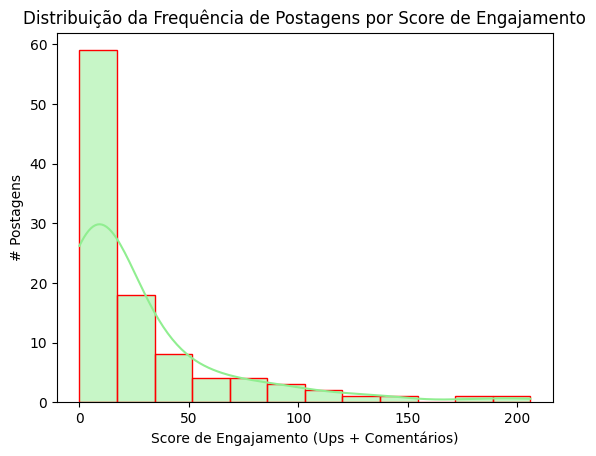

In [199]:
sns.histplot(df['engagement_score'], bins=12, kde=True, stat='count', color='lightgreen', edgecolor='red')

plt.xlabel('Score de Engajamento (Ups + Comentários)')
plt.ylabel('# Postagens')
plt.title('Distribuição da Frequência de Postagens por Score de Engajamento')

plt.show()

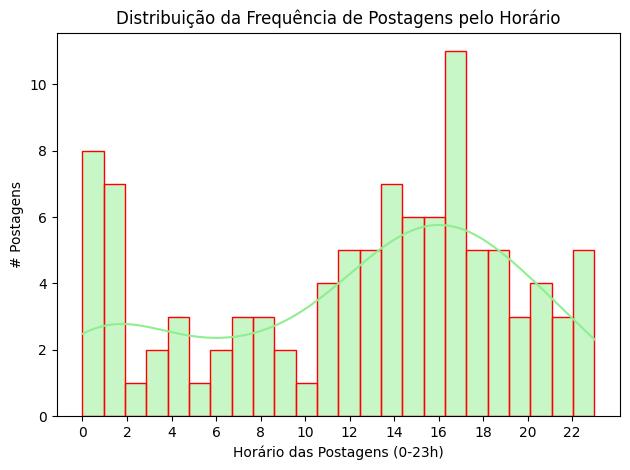

In [200]:
sns.histplot(df['post_hour'], bins=24, kde=True, stat='count', color='lightgreen', edgecolor='red')


plt.xlabel('Horário das Postagens (0-23h)') 
plt.ylabel('# Postagens')
plt.title('Distribuição da Frequência de Postagens pelo Horário') 

plt.xticks(range(0, 24, 2))
plt.tight_layout()

plt.show()

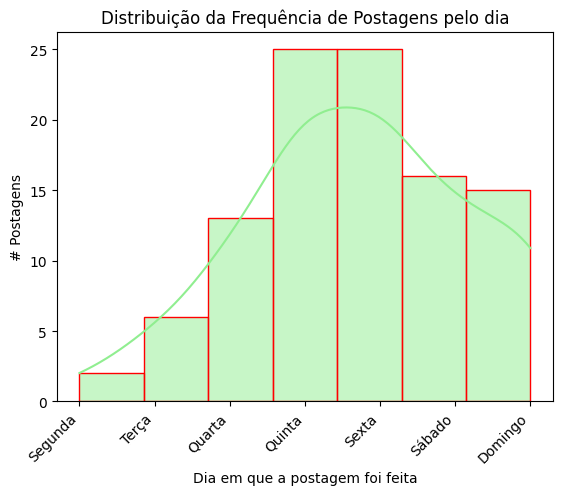

In [201]:
sns.histplot(df['post_day_of_week'], bins=7, kde=True, stat='count', color='lightgreen', edgecolor='red')


plt.xlabel('Dia em que a postagem foi feita') 
plt.ylabel('# Postagens')
plt.title('Distribuição da Frequência de Postagens pelo dia') 

plt.xticks(range(7), ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'], rotation=45, ha='right')

plt.show()

## Análise de Correlação entre os Atributos
- Para esta atividade, serão selecionadas as colunas referentes ao engajamento dos posts, como:
- ups
- upvote_ratio
- num_comments
- title_sentiment_score
- selftext_sentiment_score

A escolha dessas colunas tem como intuito verificar a correlação desses atributos. Além disso, o cálculo da correlação será feito utilizando a função corr() para encontrar a correlação entre as colunas do Dataframe, e este cálculo é feito utilizando o método "Pearson". Dessa forma, o Dataframe de saída pode ser interpretado como, para qualquer célula, a correlação da variável de linha com a variável de coluna é o valor da célula.

In [202]:
df_aux = df[['ups', 'upvote_ratio', 'num_comments', 'title_sentiment_score', 'selftext_sentiment_score']].copy()

In [203]:
df_aux = df_aux.corr(method='pearson')

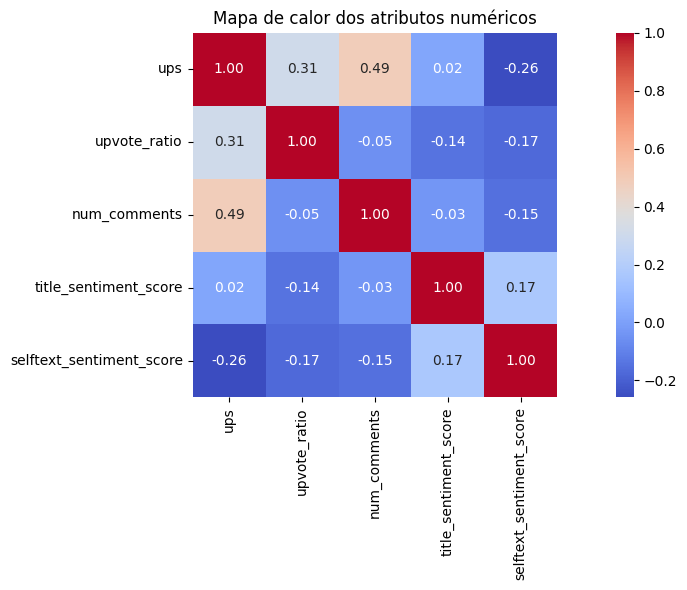

In [204]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df_aux, fmt='.2f', square=True, linecolor='white', annot=True, cmap="coolwarm");
plt.title('Mapa de calor dos atributos numéricos')
plt.tight_layout()

## Escolhas dos atributos mais relevante
Os atributos escolhidos nesta parte serão os seguintes:
- selftext_sentiment_score
- post_hour
   
A escolha desses atributos teve como base a escolha da técnica de mineração de dados para essa atividade: Clustering. Portanto, para a aplicação dessa técnica, o objetivo foi escolher um subconjunto de variáveis que melhor representasse as características distintas das postagens.

## Técnica de mineração escolhida: Agrupamento (Clustering)

A escolha dessa técnica foi com base no objetivo de investigar se o horário da postagem afeta o tom sentimental. Dessa forma, será utilizado o algorítmo k-means no sentindo de encontrar atributos baseados nesses atributos. Contudo, ao trabalhar com algoritmos baseados em distância, é necessário normalizar os dados pois as variáveis com escalas diferentes terão pesos diferentes na fórmula de distância. Dessa forma, será realizado, primeiramente, a normalização dos dados.

### Normalização e aplicação do elbow method

O objetivo da normalização é garantir que todas as características tenham escalas semelhantes, o que ajuda a evitar que certas características dominem o processo de modelagem devido aos seus valores numéricos maiores. Isso ajudará a redimensionar os dados em uma escala comum.

Quando aplicamos o StandardScaler aos dados, ele faz uso da distribuição normal e, portanto, transforma cada valor nos dados de forma que a média dos dados padronizados seja zero e o desvio padrão seja igual a um. Essa transformação garante que os dados estejam em uma escala comum, o que é útil para muitos algoritmos de aprendizado de máquina, especialmente aqueles que são sensíveis à escala dos atributos.

O objetivo de utilizar dessa distribuição para Machine Learning é de simplificar o processo de reconhecimento dos dados pela máquina evitando problemas como Bias (algoritmo enviesado), além de prevenir falhas de sobreajuste e subajuste.

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from math import sqrt

In [206]:
scaler = StandardScaler()

In [207]:
df[['selftext_sentiment_score_k', 'post_hour_k']] = scaler.fit_transform(df[['selftext_sentiment_score', 'post_hour']])

In [209]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.title("Método do Cotovelo")
    plt.xlabel('Numer of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

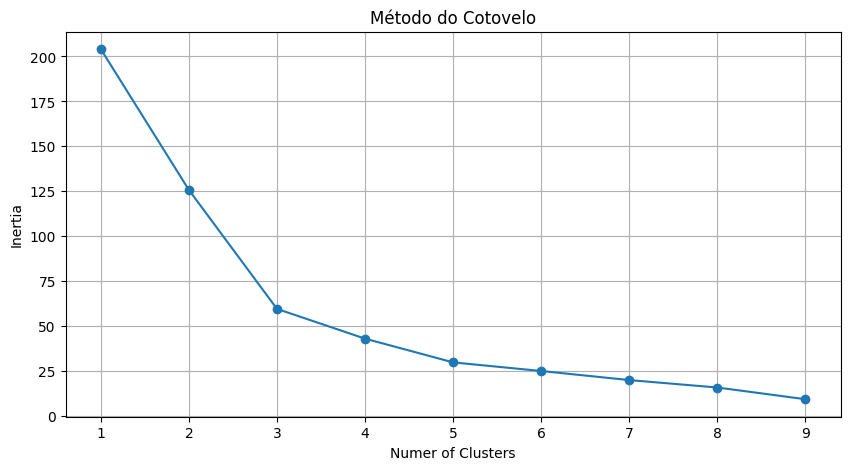

In [210]:
optimise_k_means(df[['selftext_sentiment_score_k', 'post_hour_k']], 10)

### Aplicação do algoritmo K-Means
- Agora, como o número de clusters definido para K = 3, é possível aplicar o algoritmo.

In [211]:
kmeans = KMeans(n_clusters=3)

In [212]:
kmeans.fit(df_normalized)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [213]:
df['kmeans_3'] = kmeans.labels_

## Plotando os resultados
A fim de melhorar a visualização, foi utilizado o jitter com a finalidade de dispersar os pontos e melhorar a visualização dos dados que se sobrepõem.

In [215]:
sentiment_labels = {-1: 'Negativo', 0: 'Neutro', 1: 'Positivo'}

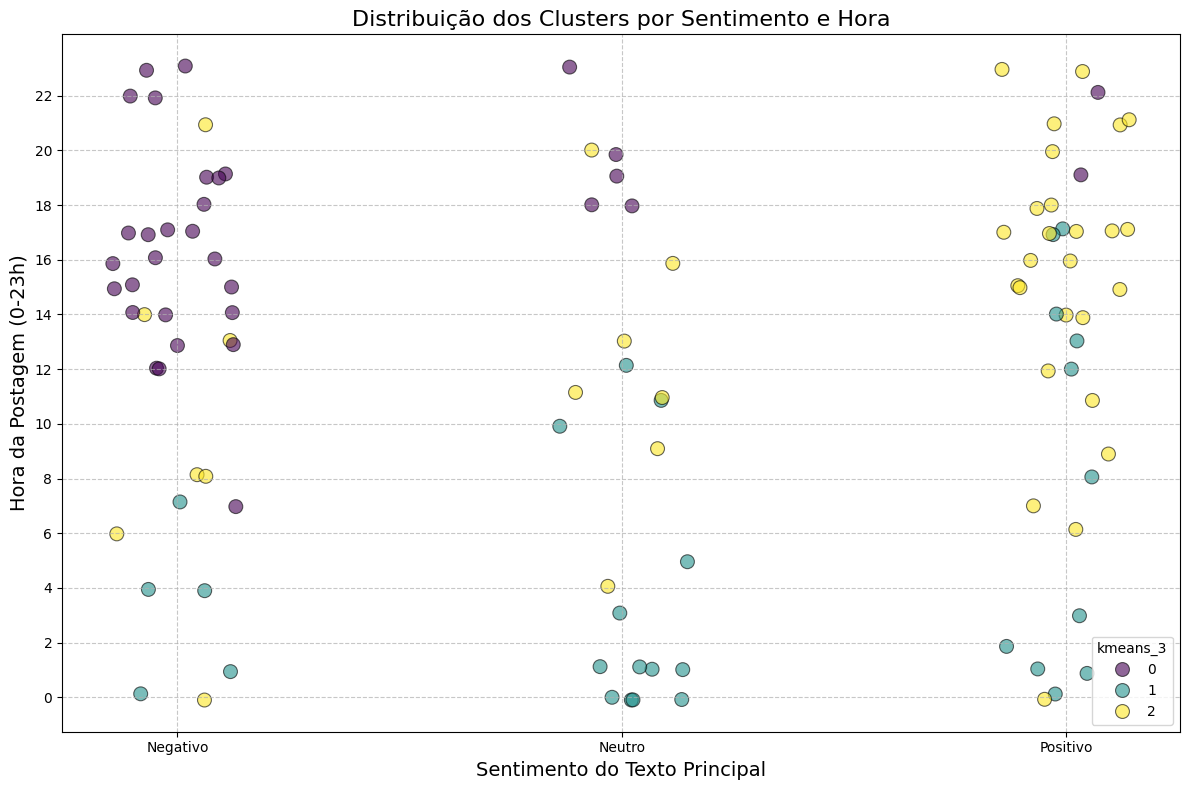

In [254]:
plt.figure(figsize=(12, 8)) 

x_jittered = df['selftext_sentiment_score'] + (np.random.rand(len(df)) - 0.5) * 0.3

y_jittered = df['post_hour'] + (np.random.rand(len(df)) - 0.5) * 0.3

sns.scatterplot(
    x=x_jittered,
    y=y_jittered,
    hue='kmeans_3',
    data=df,
    palette='viridis',
    s=100, 
    alpha=0.6, 
    edgecolor='black'
)

plt.xlabel('Sentimento do Texto Principal', fontsize=14)
plt.ylabel('Hora da Postagem (0-23h)', fontsize=14)
plt.title('Distribuição dos Clusters por Sentimento e Hora', fontsize=16)

plt.xticks([-1, 0, 1], ['Negativo', 'Neutro', 'Positivo'])

plt.yticks(range(0, 24, 2))

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [252]:
df_aux = df[['engagement_score', 'title_sentiment_score', 'selftext_sentiment_score', 'post_hour', 'post_day_of_week', 'kmeans_3']]

### Perfis dos clusters

In [253]:
cluster_profiles_means = df_aux.groupby('kmeans_3').mean(numeric_only=True)
cluster_profiles_means = cluster_profiles_means.round(2)

print("Perfis dos Clusters (Médias dos Atributos Numéricos por Cluster):")
print(cluster_profiles_means)

Perfis dos Clusters (Médias dos Atributos Numéricos por Cluster):
          engagement_score  title_sentiment_score  selftext_sentiment_score  \
kmeans_3                                                                      
0                    41.67                  -0.33                     -0.73   
1                    17.38                  -0.62                      0.21   
2                    23.72                   0.65                      0.48   

          post_hour  post_day_of_week  
kmeans_3                               
0             17.09              3.52  
1              5.14              4.45  
2             13.85              3.30  


### Tamanho dos clusters

In [250]:
print(df['kmeans_3'].value_counts().sort_index())

kmeans_3
0    33
1    29
2    40
Name: count, dtype: int64
